<a href="https://colab.research.google.com/github/xxxcrttt/CASA0018----DLSN/blob/main/hearing_the_mask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import requests

API_KEY = 'ei_49d2e0a251085174300977b8b05aa9425c4f2ed3f22bfdee77e08d293aeb3c4c'

def download_data(url):
    response = requests.get(url, headers={'x-api-key': API_KEY})
    if response.status_code == 200:
        return response.content
    else:
        print(response.content)
        raise ConnectionError('Could not download data file')

X = download_data('https://studio.edgeimpulse.com/v1/api/88274/training/5/x')
Y = download_data('https://studio.edgeimpulse.com/v1/api/88274/training/5/y')

In [ ]:
with open('x_train.npy', 'wb') as file:
    file.write(X)
with open('y_train.npy', 'wb') as file:
    file.write(Y)
X = np.load('x_train.npy')
Y = np.load('y_train.npy')[:,0]

In [ ]:
import sys, os, random
import tensorflow as tf
from sklearn.model_selection import train_test_split

import logging
tf.get_logger().setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Set random seeds for repeatable results
RANDOM_SEED = 3
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

classes_values = [ "noise", "nomask", "withmask" ]
classes = len(classes_values)

Y = tf.keras.utils.to_categorical(Y - 1, classes)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

input_length = X_train[0].shape[0]

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

def get_reshape_function(reshape_to):
    def reshape(image, label):
        return tf.reshape(image, reshape_to), label
    return reshape

callbacks = []


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Conv1D, Conv2D, Flatten, Reshape, MaxPooling1D, MaxPooling2D, BatchNormalization, TimeDistributed
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

# model architecture
model = Sequential()
model.add(Reshape((int(input_length / 13), 13), input_shape=(input_length, )))
model.add(Conv1D(16, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(Dropout(0.25))
model.add(Conv1D(16, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(classes, activation='softmax', name='y_pred'))

# this controls the learning rate
opt = Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.999)
#opt = SGD(learning_rate=0.005)
#opt = RMSprop(learning_rate=0.005)

# this controls the batch size, or you can manipulate the tf.data.Dataset objects yourself
BATCH_SIZE = 32
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=False)
validation_dataset = validation_dataset.batch(BATCH_SIZE, drop_remainder=False)

# train the neural network
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history = model.fit(train_dataset, epochs=50, validation_data=validation_dataset, verbose=2, callbacks=callbacks)

# Use this flag to disable per-channel quantization for a model.
# This can reduce RAM usage for convolutional models, but may have
# an impact on accuracy.
disable_per_channel_quantization = False


Epoch 1/50
30/30 - 1s - loss: 1.0785 - accuracy: 0.4989 - val_loss: 0.8087 - val_accuracy: 0.5805 - 968ms/epoch - 32ms/step
Epoch 2/50
30/30 - 0s - loss: 0.7422 - accuracy: 0.6649 - val_loss: 0.5497 - val_accuracy: 0.7669 - 120ms/epoch - 4ms/step
Epoch 3/50
30/30 - 0s - loss: 0.5627 - accuracy: 0.7489 - val_loss: 0.4587 - val_accuracy: 0.7966 - 126ms/epoch - 4ms/step
Epoch 4/50
30/30 - 0s - loss: 0.4558 - accuracy: 0.8117 - val_loss: 0.3455 - val_accuracy: 0.8686 - 122ms/epoch - 4ms/step
Epoch 5/50
30/30 - 0s - loss: 0.3767 - accuracy: 0.8457 - val_loss: 0.3200 - val_accuracy: 0.8771 - 128ms/epoch - 4ms/step
Epoch 6/50
30/30 - 0s - loss: 0.3295 - accuracy: 0.8660 - val_loss: 0.4583 - val_accuracy: 0.8093 - 132ms/epoch - 4ms/step
Epoch 7/50
30/30 - 0s - loss: 0.3129 - accuracy: 0.8670 - val_loss: 0.2327 - val_accuracy: 0.9280 - 128ms/epoch - 4ms/step
Epoch 8/50
30/30 - 0s - loss: 0.3101 - accuracy: 0.8500 - val_loss: 0.2067 - val_accuracy: 0.9068 - 119ms/epoch - 4ms/step
Epoch 9/50
30/3

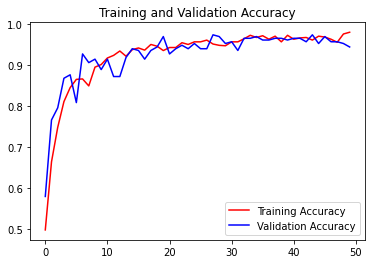

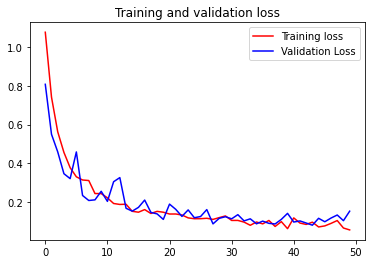

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline 

# import matplotlib libaray
import matplotlib.pyplot as plt

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy)) # get number of the epochs

# --- plot the training and validation accuracy per epoch ----
plt.plot(epochs, accuracy, 'r', label='Training Accuracy')
plt.plot(epochs, val_accuracy,'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc=0)
plt.figure()


# --- plot the training and validation loss per epoch ---
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()